In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs
from typing import List, Union, Any, Optional, Dict



from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning, InterpolationWarning


from sklearn import set_config
from sklearn.metrics import mean_squared_error, mean_absolute_error


set_config(
    display='diagram',
    transform_output="pandas"
)

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', InterpolationWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # set to 1 to avoid tensorflow warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
train_df = pd.read_csv('./Data/train_df.csv')
test_df = pd.read_csv('./Data/test_df.csv')
val_df = pd.read_csv('./Data/val_df.csv')
print(train_df.shape, val_df.shape, test_df.shape)

(24210, 9) (3459, 9) (6918, 9)


## Deep Learning for Time Series

In [25]:
class DataHandler:
    def __init__(self, label_columns: Optional[List[str]] = None):
        """
        Initialize the DataHandler.

        label_columns: list of column name(s) to be used as labels
        """
        self.label_columns = label_columns
        self.column_indices = None
        self.label_columns_indices = None

    def set_data(self, data: Dict[str, np.ndarray]):
        """
        Set data for training, validation, and testing. Also create indices for the columns and label columns.

        data: a dictionary with keys 'train', 'val', and 'test' and their corresponding dataframes as values
        """
        self.train_df = data['train']
        self.val_df = data['val']
        self.test_df = data['test']

        self.column_indices = {name: i for i, name in enumerate(self.train_df.columns)}
        if self.label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(self.label_columns)}

class WindowManager:
    def __init__(self, input_width: int, label_width: int, shift: int, data_handler: DataHandler):
        """
        Initialize the WindowManager.

        input_width: number of steps (hours) of the input
        label_width: number of steps (hours) of the output label
        shift: number of steps to shift the window for the next prediction
        data_handler: a DataHandler instance to handle data
        """
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.data_handler = data_handler

        self.total_window_size = input_width + shift
        self.input_indices = np.arange(self.total_window_size)[:input_width]
        self.label_indices = np.arange(self.total_window_size)[-label_width:]

    def split_to_inputs_labels(self, features):
        """
        Split the features into inputs and labels based on the input and label widths.
        """
        inputs = features[:, :self.input_width, :]
        labels = features[:, -self.label_width:, :]

        if self.data_handler.label_columns is not None:
            labels = tf.stack([labels[:, :, self.data_handler.column_indices[name]] for name in self.data_handler.label_columns], axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data):
        """
        Create a time series dataset from the data.
        """
        data = np.array(data, dtype=np.float32)
        ds = keras.preprocessing.timeseries_dataset_from_array(
            data=data, targets=None, sequence_length=self.total_window_size,
            sequence_stride=1, shuffle=False, batch_size=32,
        )
        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        """
        Get the training dataset.
        """
        return self.make_dataset(self.data_handler.train_df)

    @property
    def val(self):
        """
        Get the validation dataset.
        """
        return self.make_dataset(self.data_handler.val_df)

    @property
    def test(self):
        """
        Get the testing dataset.
        """
        return self.make_dataset(self.data_handler.test_df)


In [26]:
def create_data(input_width):
    """
    Create data for training, validation, and testing.
    """
    data_handler = DataHandler(label_columns=['Global_active_power'])
    data_handler.set_data({
        'train': train_df,
        'val': val_df,
        'test': test_df
    })

    window = WindowManager(input_width=input_width, label_width=24, shift=24, data_handler=data_handler)

    # create normalized data
    normalizer = layers.Normalization(axis=-1)

    # Adapt it to the training data
    normalizer.adapt(window.train.map(lambda x, y: x))

    normalized_train_ds = window.train.map(lambda x, y: (normalizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    normalized_val_ds = window.val.map(lambda x, y: (normalizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    normalized_test_ds = window.test.map(lambda x, y: (normalizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)


    return {
        'train': normalized_train_ds,
        'val': normalized_val_ds,
        'test': normalized_test_ds
    }

In [27]:
def make_predictions(model, df):

    # Create empty lists to hold labels and predictions
    test_labels = []
    test_predictions = []

    # Loop over all batches in the test dataset
    for test_inputs, test_batch_labels in df['test']:
        # Make predictions for this batch
        test_batch_predictions = model.predict(test_inputs, verbose=0)

        # Append the labels and predictions to our lists
        test_labels.append(test_batch_labels.numpy())
        test_predictions.append(test_batch_predictions)

    # Concatenate the labels and predictions from all batches
    test_labels = np.concatenate(test_labels)
    test_predictions = np.concatenate(test_predictions)

    return {
        'labels': test_labels,
        'predictions': test_predictions
    }

In [39]:
def set_seed(seed):
    keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

In [40]:
def compile_and_fit(model, df, init_lr=0.001, max_epochs=50):


    lr_reduce_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=3, verbose=0,
        mode='auto', min_delta=0.0001, min_lr=0.000001
    )

    # early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                                patience=patience, mode='min')

    model.compile(loss="mse",
                  optimizer=keras.optimizers.Adam(learning_rate=init_lr),
                  metrics=[keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(df['train'],
                       epochs=max_epochs,
                       validation_data=df['val'],
                       callbacks=[lr_reduce_callback]
                       )
    
    return history

## RNN (LSTM)

In [41]:
lstm_df=create_data(input_width=24)
set_seed(42)

lstm_model = keras.Sequential([
    layers.LSTM(32, return_sequences=True),
    layers.Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, lstm_df, max_epochs=50)

Epoch 1/50
756/756 [==============================] - 8s 9ms/step - loss: 6035.8730 - mean_absolute_error: 54.0024 - val_loss: 6210.6934 - val_mean_absolute_error: 57.6142 - lr: 0.0010
Epoch 2/50
756/756 [==============================] - 6s 9ms/step - loss: 4280.2812 - mean_absolute_error: 44.6366 - val_loss: 4650.0767 - val_mean_absolute_error: 50.8638 - lr: 0.0010
Epoch 3/50
756/756 [==============================] - 6s 9ms/step - loss: 3526.9646 - mean_absolute_error: 43.3482 - val_loss: 3883.9141 - val_mean_absolute_error: 47.8489 - lr: 0.0010
Epoch 4/50
756/756 [==============================] - 6s 9ms/step - loss: 3225.3279 - mean_absolute_error: 43.3567 - val_loss: 3783.2261 - val_mean_absolute_error: 47.2330 - lr: 0.0010
Epoch 5/50
756/756 [==============================] - 6s 9ms/step - loss: 2944.8347 - mean_absolute_error: 40.5365 - val_loss: 3210.7869 - val_mean_absolute_error: 40.9881 - lr: 0.0010
Epoch 6/50
756/756 [==============================] - 6s 9ms/step - loss: 2

In [42]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 32)            5248      
                                                                 
 dense_2 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


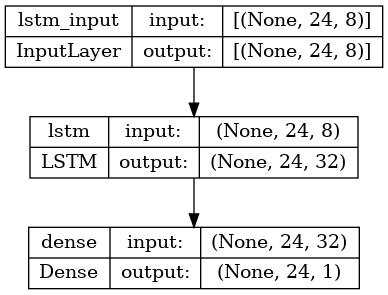

In [32]:
dot_img_file = 'results/lstm_model.png'
keras.utils.plot_model(lstm_model, to_file=dot_img_file, show_shapes=True)

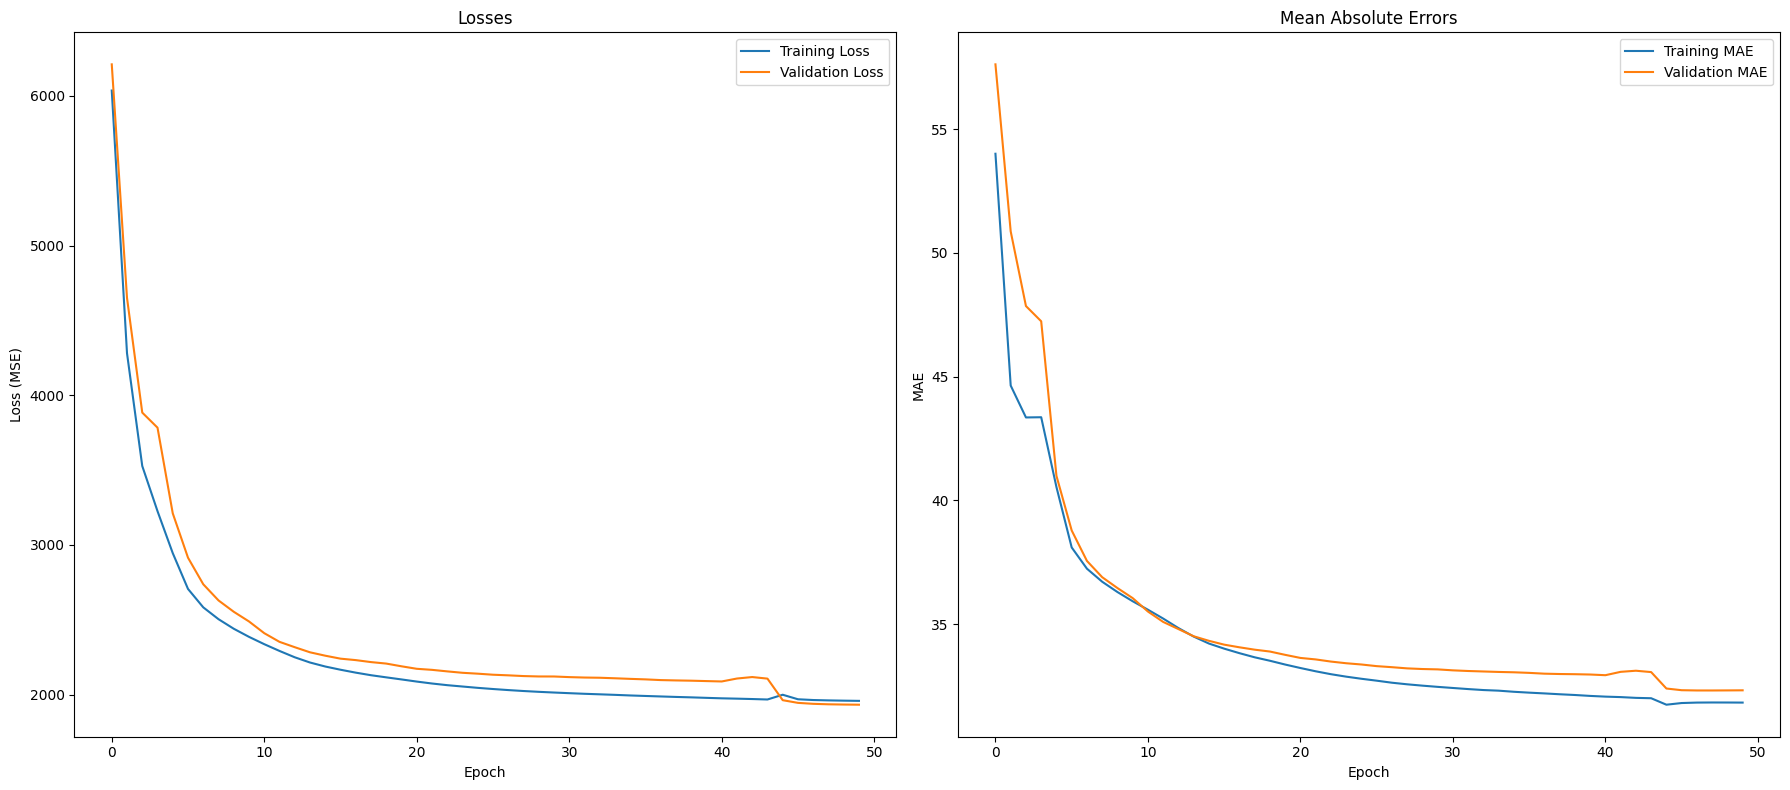

In [43]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

plt.subplot(1, 2, 2)
plt.plot(history_df['mean_absolute_error'], label='Training MAE')
plt.plot(history_df['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.title('Mean Absolute Errors')
plt.xlabel('Epoch')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

In [74]:
lstm_preds=make_predictions(lstm_model, lstm_df)

true_vals_lstm=lstm_preds['labels'].ravel()
lstm_preds=lstm_preds['predictions'].ravel()
evaluate_model(true_vals_lstm, lstm_preds, 'RNN-LSTM')

,RNN-LSTM
RMSE,36.139565
MBE,-0.937574
MAE,26.935583


## CNN

In [60]:
cnn_df=create_data(input_width=26)
set_seed(42)

cnn_model = keras.Sequential([
    layers.Conv1D(32, activation='relu', kernel_size=(3)),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(1, kernel_initializer=tf.initializers.zeros),
])

history_cnn = compile_and_fit(cnn_model, cnn_df, init_lr=0.0001, max_epochs=50)

Epoch 1/50
756/756 [==============================] - 6s 7ms/step - loss: 7108.0688 - mean_absolute_error: 63.3297 - val_loss: 8233.2812 - val_mean_absolute_error: 72.1307 - lr: 1.0000e-04
Epoch 2/50
756/756 [==============================] - 5s 7ms/step - loss: 5064.7373 - mean_absolute_error: 48.1903 - val_loss: 4565.4185 - val_mean_absolute_error: 49.1891 - lr: 1.0000e-04
Epoch 3/50
756/756 [==============================] - 5s 7ms/step - loss: 3084.7637 - mean_absolute_error: 39.6694 - val_loss: 3157.6323 - val_mean_absolute_error: 41.8488 - lr: 1.0000e-04
Epoch 4/50
756/756 [==============================] - 5s 7ms/step - loss: 2675.9087 - mean_absolute_error: 38.6567 - val_loss: 2799.5583 - val_mean_absolute_error: 39.6297 - lr: 1.0000e-04
Epoch 5/50
756/756 [==============================] - 5s 7ms/step - loss: 2522.9050 - mean_absolute_error: 37.8055 - val_loss: 2610.8320 - val_mean_absolute_error: 38.1869 - lr: 1.0000e-04
Epoch 6/50
756/756 [==============================] - 5

In [61]:
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 24, 32)            800       
                                                                 
 dense_11 (Dense)            (None, 24, 32)            1056      
                                                                 
 dense_12 (Dense)            (None, 24, 1)             33        
                                                                 
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
_________________________________________________________________


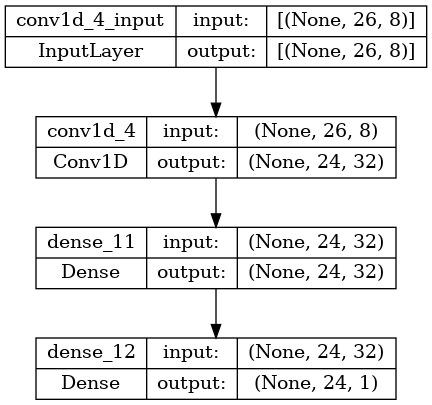

In [62]:
dot_img_file = 'results/cnn_model.png'
keras.utils.plot_model(cnn_model, to_file=dot_img_file, show_shapes=True)

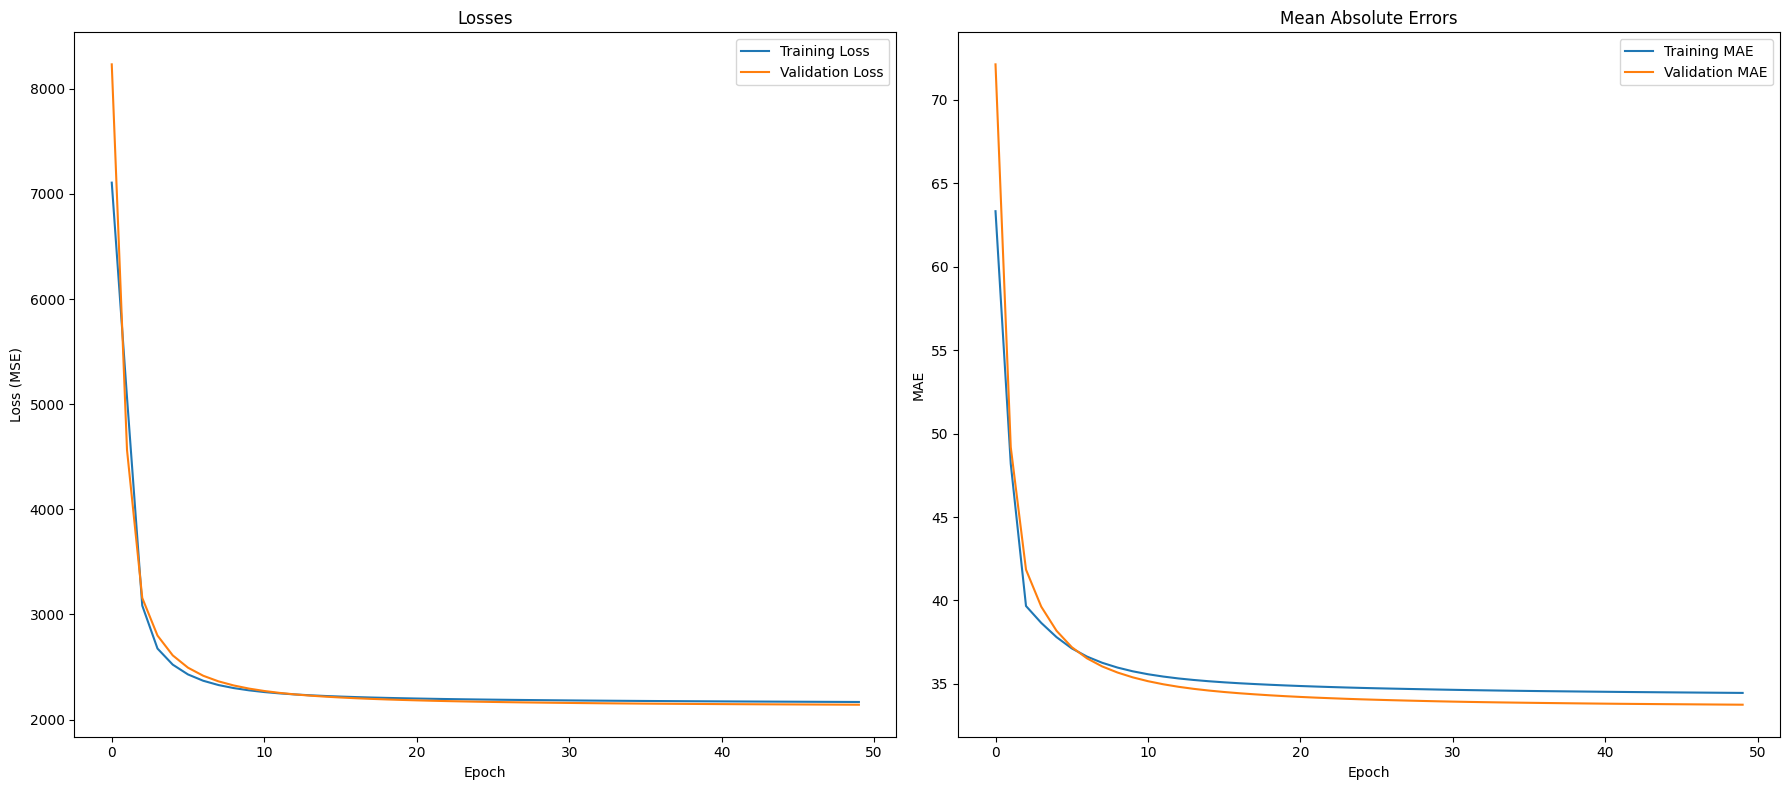

In [63]:
history_df = pd.DataFrame(history_cnn.history)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

plt.subplot(1, 2, 2)
plt.plot(history_df['mean_absolute_error'], label='Training MAE')
plt.plot(history_df['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.title('Mean Absolute Errors')
plt.xlabel('Epoch')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

In [75]:
cnn_preds=make_predictions(cnn_model, cnn_df)

true_vals=cnn_preds['labels'].ravel()
cnn_preds=cnn_preds['predictions'].ravel()
evaluate_model(true_vals, cnn_preds, 'CNN')

,CNN
RMSE,37.180767
MBE,-0.380837
MAE,28.162018


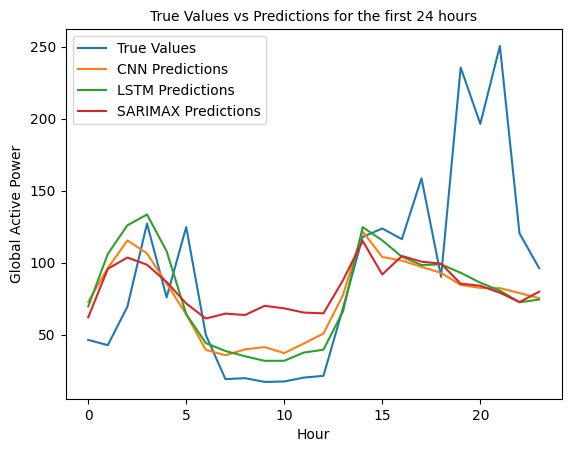

In [115]:
## plotting  predictions and true values

plt.plot(true_vals[:24], label='True Values')
plt.plot(cnn_preds[:24], label='CNN Predictions')
plt.plot(np.concatenate((lstm_preds[2:24],lstm_preds[70:72] ), axis=0), label='LSTM Predictions')
plt.plot(test_pred.values[2:26], label='SARIMAX Predictions')
plt.legend()
plt.title('True Values vs Predictions for the first 24 hours', fontsize=10)
plt.xlabel('Hour')
plt.ylabel('Global Active Power')
plt.show()

### Model Comparison Table

In [112]:
pd.concat([evaluate_model(true_vals, cnn_preds, 'CNN'), evaluate_model(true_vals_lstm, lstm_preds, 'RNN-LSTM'), sarimax_metric], axis=1)

,CNN,RNN-LSTM,SARIMAX
RMSE,37.180767,36.139565,49.773119
MBE,-0.380837,-0.937574,-29.125007
MAE,28.162018,26.935583,43.074521
